In [1]:
import os
import warnings
warnings.filterwarnings('ignore')

WORKING_DIR = 'C:/term_project/'
os.chdir(WORKING_DIR)
print(os.getcwd())

C:\term_project


In [2]:
# IMPORTS & ENV VARS

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
import json

DATA_DIR = os.path.join(WORKING_DIR, 'data')
RESULT_DIR = os.path.join(WORKING_DIR, 'results')

LAG_WEEKS = [4, 8, 12, 16, 20, 24, 28, 32, 36, 41, 52]
ROLLING_WEEKS = [4, 8, 12, 16, 20, 24, 28, 32, 36, 41, 52]
DELTA_WEEKS = [1, 2, 3, 4, 8, 12, 16, 20, 24, 28, 32, 36, 41, 52]

FEATURE_SEL_MAX_FEATURES = 300

OVERSAMPLE_THRESHOLD = 15
OVERSAMPLE_MULTIPLIER = 5

TRAIN_RATIO = 0.65
VAL_RATIO = 0.15

SVM_PARAM_GRID = {
    'C': [1.6], 
    'epsilon': [0.01], 
    'kernel': ['poly'], 
    'degree': [3], 
    'gamma': ['scale', 'auto', 0.01, 0.1] 
}

In [11]:
# LOAD TRAIN DATA

train_features = pd.read_csv(os.path.join(DATA_DIR, 'dengue_features_train.csv'), index_col=[0, 1, 2])
train_labels = pd.read_csv(os.path.join(DATA_DIR, 'dengue_labels_train.csv'), index_col=[0, 1, 2])

# Seperate data for San Juan
sj_train_features = train_features.loc['sj']
sj_train_labels = train_labels.loc['sj']

# Separate data for Iquitos
iq_train_features = train_features.loc['iq']
iq_train_labels = train_labels.loc['iq']

print("San Juan")
print("features: ", sj_train_features.shape)
print("labels  : ", sj_train_labels.shape)

print("\nIquitos")
print("features: ", iq_train_features.shape)
print("labels  : ", iq_train_labels.shape)

San Juan
features:  (936, 21)
labels  :  (936, 1)

Iquitos
features:  (520, 21)
labels  :  (520, 1)


In [12]:
print("San Juan Features:", sj_train_features.columns.tolist())
print("San Juan Labels:", sj_train_labels.columns.tolist())

San Juan Features: ['week_start_date', 'ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw', 'precipitation_amt_mm', 'reanalysis_air_temp_k', 'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k', 'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k', 'reanalysis_precip_amt_kg_per_m2', 'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm', 'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k', 'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c', 'station_min_temp_c', 'station_precip_mm']
San Juan Labels: ['total_cases']


In [14]:
# PREPROCESS DATA 

def preprocess_city_data(features, labels=None):
    """
    Merges features and labels, converts week_start_date to index,
    and handles missing values.
    """
    # 1. Merge features and labels if labels are provided
    if labels is not None:
        df = features.join(labels)
    else:
        df = features.copy()
    
    # 2. Reset index to move 'year' and 'weekofyear' from index to columns
    # This preserves them as features.
    df.reset_index(inplace=True)
    
    # 3. Convert week_start_date to datetime
    df['week_start_date'] = pd.to_datetime(df['week_start_date'])
    
    # 4. Set week_start_date as index
    df.set_index('week_start_date', inplace=True)
    
    # 5. Drop 'city' column as it's constant for each model and not numeric
    if 'city' in df.columns:
        df.drop(columns=['city'], inplace=True)
    
    # 6. Fill Missing Values (Forward Fill for time series)
    df = df.ffill()
    
    return df

# Apply to San Juan and Iquitos
sj_train = preprocess_city_data(sj_train_features, sj_train_labels)
iq_train = preprocess_city_data(iq_train_features, iq_train_labels)

print("San Juan Preprocessed Shape:", sj_train.shape)
print("Iquitos Preprocessed Shape:", iq_train.shape)
sj_train.head()

San Juan Preprocessed Shape: (936, 23)
Iquitos Preprocessed Shape: (520, 23)


,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
week_start_date,,,,,,,,,,,,,,,,,,,,,
1990-04-30,1990,18,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,...,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1990-05-07,1990,19,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,...,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
1990-05-14,1990,20,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,...,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
1990-05-21,1990,21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,...,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
1990-05-28,1990,22,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,...,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6


In [16]:
# DROP TIME FEATURES "year", "week_of_year"

sj_train = sj_train.drop(columns=["year", "weekofyear"])
iq_train = iq_train.drop(columns=["year", "weekofyear"])

print("San Juan Final: ", sj_train.shape)
print("Iquitos Final: ", iq_train.shape)

San Juan Final:  (936, 21)
Iquitos Final:  (520, 21)


In [17]:
# FEATURE EXTRACTION

def create_features(df, lag_weeks=LAG_WEEKS, rolling_weeks=ROLLING_WEEKS, delta_weeks=DELTA_WEEKS):
    """
    Creates lag and rolling window features.
    """
    df_eng = df.copy()
    
    # List of columns to create features for (exclude labels and non-numeric if any)
    # Typically climate variables
    feature_cols = [c for c in df.columns if c not in ['total_cases', 'year', 'weekofyear']]
    
    new_features = []
    
    for col in feature_cols:
        # Lag features
        for lag in lag_weeks:
            new_features.append(
                df_eng[col].shift(lag).rename(f'{col}_lag_{lag}')
            )

        # Delta features
        for delta in delta_weeks:
            new_features.append(
                (df_eng[col] - df_eng[col].shift(delta)).rename(f'{col}_delta_{delta}')
            )
            
        # Rolling features
        for window in rolling_weeks:
            rolling_col = df_eng[col].rolling(window=window)
            
            new_features.append(rolling_col.mean().rename(f'{col}_rolling_mean_{window}'))
            new_features.append(rolling_col.std().rename(f'{col}_rolling_std_{window}'))
            new_features.append(rolling_col.var().rename(f'{col}_rolling_var_{window}'))
            new_features.append(rolling_col.min().rename(f'{col}_rolling_min_{window}'))
            new_features.append(rolling_col.max().rename(f'{col}_rolling_max_{window}'))
            new_features.append(rolling_col.median().rename(f'{col}_rolling_median_{window}'))
            new_features.append(rolling_col.skew().rename(f'{col}_rolling_skew_{window}'))
            new_features.append(rolling_col.kurt().rename(f'{col}_rolling_kurt_{window}'))

        # # Z-Score features
        # for window in rolling_weeks:
        #     rolling_mean = df_eng[col].rolling(window=window).mean()
        #     rolling_std = df_eng[col].rolling(window=window).std()
        #     z_score = ((df_eng[col] - rolling_mean) / rolling_std).rename(f'{col}_zscore_{window}')
        #     new_features.append(z_score)
            
    # Concatenate all new features at once to avoid PerformanceWarning (fragmentation)
    if new_features:
        df_features = pd.concat(new_features, axis=1)
        df_eng = pd.concat([df_eng, df_features], axis=1)
            
    # Drop rows with NaNs created by lag/rolling (or fill them)
    # For training, we usually drop the initial rows.
    df_eng.dropna(inplace=True)
    
    return df_eng

# Create engineered features
sj_train_eng = create_features(sj_train)
iq_train_eng = create_features(iq_train)

print("San Juan Engineered Shape:", sj_train_eng.shape)
print("Iquitos Engineered Shape:", iq_train_eng.shape)

San Juan Engineered Shape: (884, 2281)
Iquitos Engineered Shape: (468, 2281)


In [18]:
# LOAD SELECTED FEATURES

sj_features_path = os.path.join(RESULT_DIR, "sj_selected_features.json")
iq_features_path = os.path.join(RESULT_DIR, "iq_selected_features.json")

with open(sj_features_path, 'r') as f:
    sj_features_selected = json.load(f)

with open(iq_features_path, 'r') as f:
    iq_features_selected = json.load(f)

print(f"Loaded {len(sj_features_selected)} San Juan features")
print(f"Loaded {len(iq_features_selected)} Iquitos features")

# Filter dataframes to include only selected features plus target
sj_train_eng = sj_train_eng[sj_features_selected + ['total_cases']]
iq_train_eng = iq_train_eng[iq_features_selected + ['total_cases']]

print("\nSan Juan Selected Shape:", sj_train_eng.shape)
print("Iquitos Selected Shape:", iq_train_eng.shape)

Loaded 17 San Juan features
Loaded 24 Iquitos features

San Juan Selected Shape: (884, 18)
Iquitos Selected Shape: (468, 25)


In [20]:
# SPLIT DATA & OVERSAMPLE TRAIN

def oversample_peaks(df, target_col='total_cases', threshold=OVERSAMPLE_THRESHOLD, multiplier=OVERSAMPLE_MULTIPLIER):
    """
    Oversamples rows where target > threshold by duplicating them 'multiplier' times.
    """
    peaks = df[df[target_col] > threshold]
    
    if len(peaks) == 0:
        return df
        
    oversampled_data = [df]
    for _ in range(multiplier):
        oversampled_data.append(peaks)
        
    df_oversampled = pd.concat(oversampled_data)
    # Sort by index to maintain time order (optional, but good for visualization)
    df_oversampled = df_oversampled.sort_index()
    
    return df_oversampled

def split_and_oversample(df, target_col='total_cases', train_ratio=TRAIN_RATIO, val_ratio=VAL_RATIO, oversample=True):
    """
    Splits data into Train, Validation, and Test.
    Applies oversampling ONLY to the Training set.
    """
    n = len(df)
    train_end = int(n * train_ratio)
    val_end = int(n * (train_ratio + val_ratio))
    
    # Split
    train = df.iloc[:train_end]
    val = df.iloc[train_end:val_end]
    test = df.iloc[val_end:]
    
    # Oversample Train
    if oversample:
        print(f"  Original Train Size: {len(train)}")
        train = oversample_peaks(train, target_col=target_col)
        print(f"  Oversampled Train Size: {len(train)}")
    
    # Separate X and y
    X_train = train.drop(columns=[target_col])
    y_train = train[target_col]
    
    X_val = val.drop(columns=[target_col])
    y_val = val[target_col]
    
    X_test = test.drop(columns=[target_col])
    y_test = test[target_col]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

print("Splitting and Oversampling San Juan...")
X_train_sj, y_train_sj, X_val_sj, y_val_sj, X_test_sj, y_test_sj = split_and_oversample(sj_train_eng)

print("\nSplitting and Oversampling Iquitos...")
X_train_iq, y_train_iq, X_val_iq, y_val_iq, X_test_iq, y_test_iq = split_and_oversample(iq_train_eng)

print("\nSan Juan Shapes (Train/Val/Test):", X_train_sj.shape, X_val_sj.shape, X_test_sj.shape)
print("Iquitos Shapes (Train/Val/Test):", X_train_iq.shape, X_val_iq.shape, X_test_iq.shape)

Splitting and Oversampling San Juan...
  Original Train Size: 574
  Oversampled Train Size: 2604

Splitting and Oversampling Iquitos...
  Original Train Size: 304
  Oversampled Train Size: 499

San Juan Shapes (Train/Val/Test): (2604, 17) (133, 17) (177, 17)
Iquitos Shapes (Train/Val/Test): (499, 24) (70, 24) (94, 24)


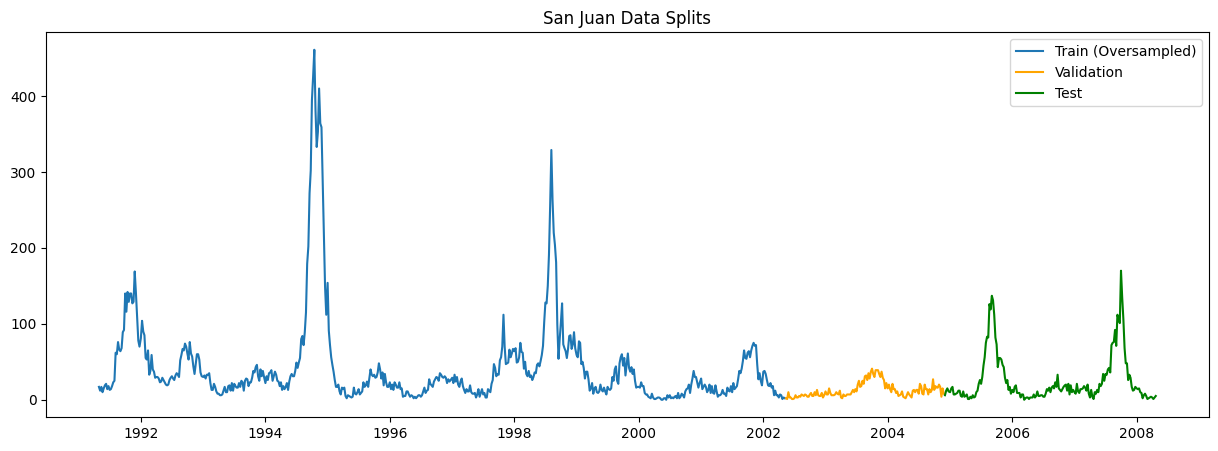

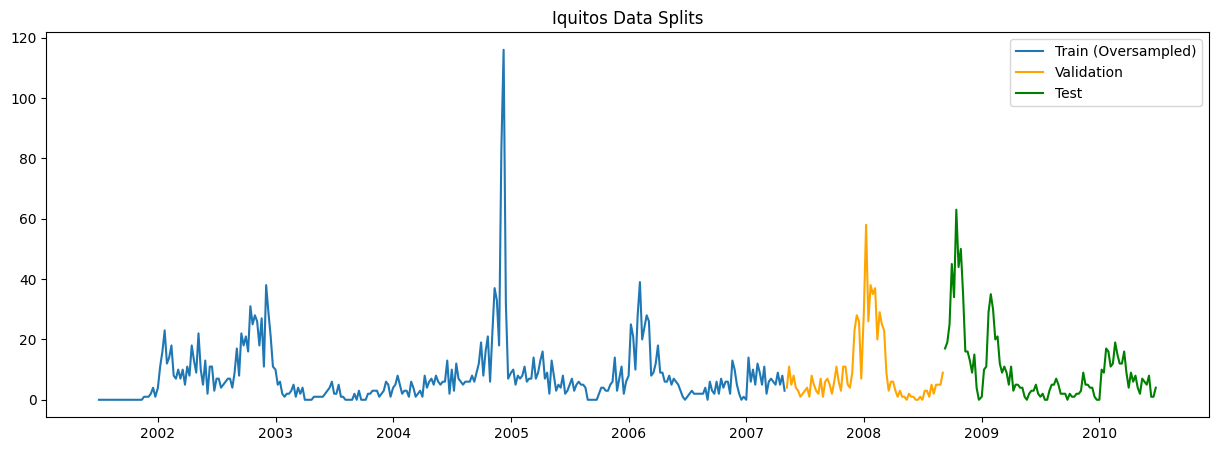

In [21]:
# VISUALIZE SPLITS

def plot_splits(y_train, y_val, y_test, title):
    plt.figure(figsize=(15, 5))
    plt.plot(y_train.index, y_train, label='Train (Oversampled)')
    plt.plot(y_val.index, y_val, label='Validation', color='orange')
    plt.plot(y_test.index, y_test, label='Test', color='green')
    plt.title(title)
    plt.legend()
    plt.show()

plot_splits(y_train_sj, y_val_sj, y_test_sj, "San Juan Data Splits")
plot_splits(y_train_iq, y_val_iq, y_test_iq, "Iquitos Data Splits")

In [22]:
# HYPERPARAMETER TUNING WITH GRID SEARCH (VALIDATION SET)

def tune_svm(X_train, y_train, X_val, y_val):
    """
    Performs Grid Search by training on Train and evaluating on Validation set.
    """
    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    # Define parameter grid
    param_grid = list(ParameterGrid(SVM_PARAM_GRID))
    
    best_score = float('inf')
    best_params = None
    best_model = None
    best_scaler = None
    
    print(f"Tuning on {len(param_grid)} combinations...")
    
    for i, params in enumerate(param_grid):
        print(f"[{i+1}/{len(param_grid)}] Testing: {params}", end='\r')
        # Add fixed params
        current_params = params.copy()
        
        model = SVR(**current_params)
        model.fit(X_train_scaled, y_train)
        
        preds = model.predict(X_val_scaled)
        preds = np.maximum(preds, 0)
        mae = mean_absolute_error(y_val, preds)
        
        if mae < best_score:
            best_score = mae
            best_params = params
            best_model = model
            best_scaler = scaler
    
    print("\nBest Parameters:", best_params)
    print("Best MAE (Validation):", best_score)
    
    return best_model, best_scaler

# Tune San Juan
print("Tuning San Juan Model...")
best_model_sj, scaler_sj = tune_svm(X_train_sj, y_train_sj, X_val_sj, y_val_sj)

# Tune Iquitos
print("\nTuning Iquitos Model...")
best_model_iq, scaler_iq = tune_svm(X_train_iq, y_train_iq, X_val_iq, y_val_iq)

Tuning San Juan Model...
Tuning on 4 combinations...
[4/4] Testing: {'C': 1.6, 'degree': 3, 'epsilon': 0.01, 'gamma': 0.1, 'kernel': 'poly'}}'}}
Best Parameters: {'C': 1.6, 'degree': 3, 'epsilon': 0.01, 'gamma': 'scale', 'kernel': 'poly'}
Best MAE (Validation): 15.64926600851593

Tuning Iquitos Model...
Tuning on 4 combinations...
[4/4] Testing: {'C': 1.6, 'degree': 3, 'epsilon': 0.01, 'gamma': 0.1, 'kernel': 'poly'}}'}}
Best Parameters: {'C': 1.6, 'degree': 3, 'epsilon': 0.01, 'gamma': 'scale', 'kernel': 'poly'}
Best MAE (Validation): 8.817196057198482


San Juan Tuned MAE: 28.8787
Iquitos Tuned MAE: 7.7928


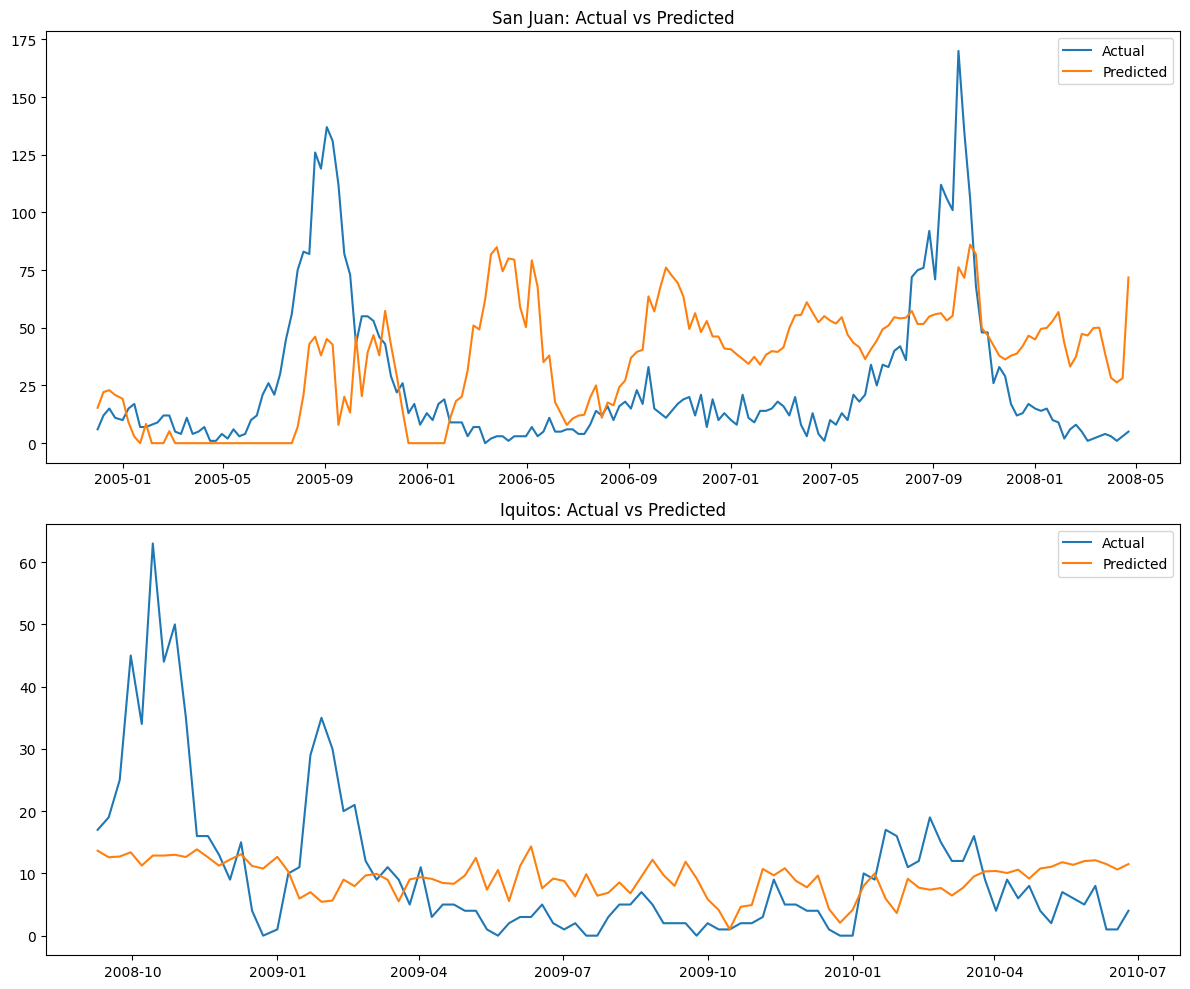

In [23]:
# EVALUATION AND VISUALIZATION

# Evaluate Tuned San Juan
X_test_sj_scaled = scaler_sj.transform(X_test_sj)
preds_sj_tuned = best_model_sj.predict(X_test_sj_scaled)
preds_sj_tuned = np.maximum(preds_sj_tuned, 0)
mae_sj_tuned = mean_absolute_error(y_test_sj, preds_sj_tuned)
print(f"San Juan Tuned MAE: {mae_sj_tuned:.4f}")

# Evaluate Tuned Iquitos
X_test_iq_scaled = scaler_iq.transform(X_test_iq)
preds_iq_tuned = best_model_iq.predict(X_test_iq_scaled)
preds_iq_tuned = np.maximum(preds_iq_tuned, 0)
mae_iq_tuned = mean_absolute_error(y_test_iq, preds_iq_tuned)
print(f"Iquitos Tuned MAE: {mae_iq_tuned:.4f}")

# Plot Results
fig, ax = plt.subplots(2, 1, figsize=(12, 10))

# San Juan
ax[0].plot(y_test_sj.index, y_test_sj, label='Actual')
ax[0].plot(y_test_sj.index, preds_sj_tuned, label='Predicted')
ax[0].set_title('San Juan: Actual vs Predicted')
ax[0].legend()

# Iquitos
ax[1].plot(y_test_iq.index, y_test_iq, label='Actual')
ax[1].plot(y_test_iq.index, preds_iq_tuned, label='Predicted')
ax[1].set_title('Iquitos: Actual vs Predicted')
ax[1].legend()


plt.tight_layout()
plt.show()
plt.close()

In [24]:
# PRINT FEATURE IMPORTANCES

print("\nSan Juan Feature Importances:")
perm_importance_sj = permutation_importance(best_model_sj, X_test_sj_scaled, y_test_sj, n_repeats=10, random_state=42)
importances_sj = pd.Series(perm_importance_sj.importances_mean, index=X_train_sj.columns)
importances_sj = importances_sj.sort_values(ascending=False)  
print(importances_sj.head(20))

print("\nIquitos Feature Importances:")
perm_importance_iq = permutation_importance(best_model_iq, X_test_iq_scaled, y_test_iq, n_repeats=10, random_state=42)
importances_iq = pd.Series(perm_importance_iq.importances_mean, index=X_train_iq.columns)
importances_iq = importances_iq.sort_values(ascending=False)    
print(importances_iq.head(20))

print("\nIntersection of Top 20 Features:")
top_20_sj = set(importances_sj.head(20).index)
top_20_iq = set(importances_iq.head(20).index)  
common_features = top_20_sj.intersection(top_20_iq)
print(common_features)


San Juan Feature Importances:
reanalysis_avg_temp_k_rolling_max_52                     0.313673
station_diur_temp_rng_c_rolling_skew_41                  0.216420
reanalysis_specific_humidity_g_per_kg_rolling_mean_16    0.152064
station_min_temp_c_lag_36                                0.099035
station_diur_temp_rng_c_rolling_skew_52                  0.089378
reanalysis_air_temp_k_delta_41                           0.054313
station_min_temp_c_rolling_kurt_16                       0.033287
ndvi_ne_rolling_kurt_24                                 -0.005060
station_max_temp_c_rolling_median_41                    -0.051655
station_diur_temp_rng_c_rolling_std_16                  -0.067609
station_max_temp_c_rolling_mean_24                      -0.073916
station_max_temp_c_rolling_mean_16                      -0.118055
station_max_temp_c_rolling_mean_28                      -0.125875
reanalysis_air_temp_k_rolling_var_20                    -0.248035
reanalysis_relative_humidity_percent_rolling_

San Juan Final Model MAE on Full Training Data: 18.0100
Iquitos Final Model MAE on Full Training Data: 5.5880


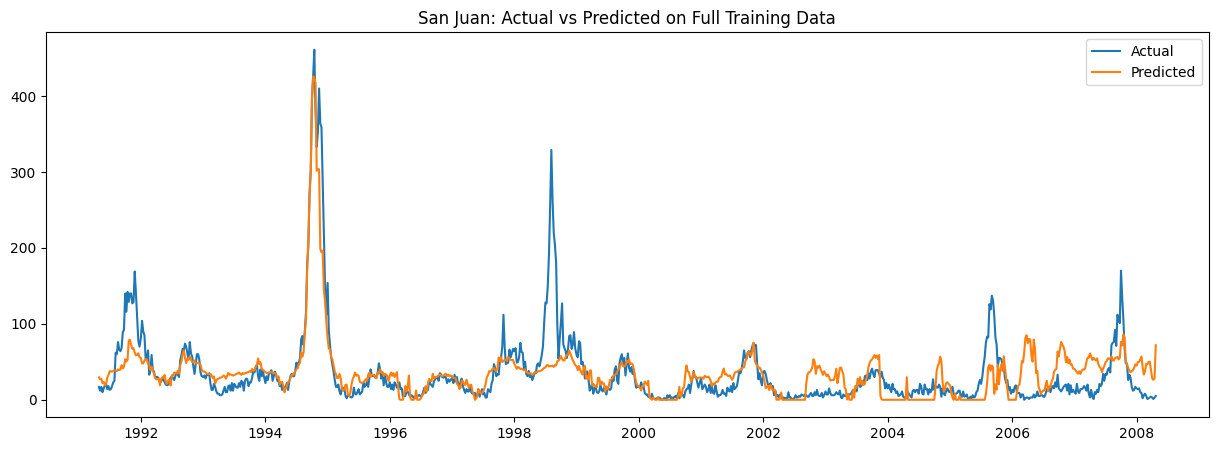

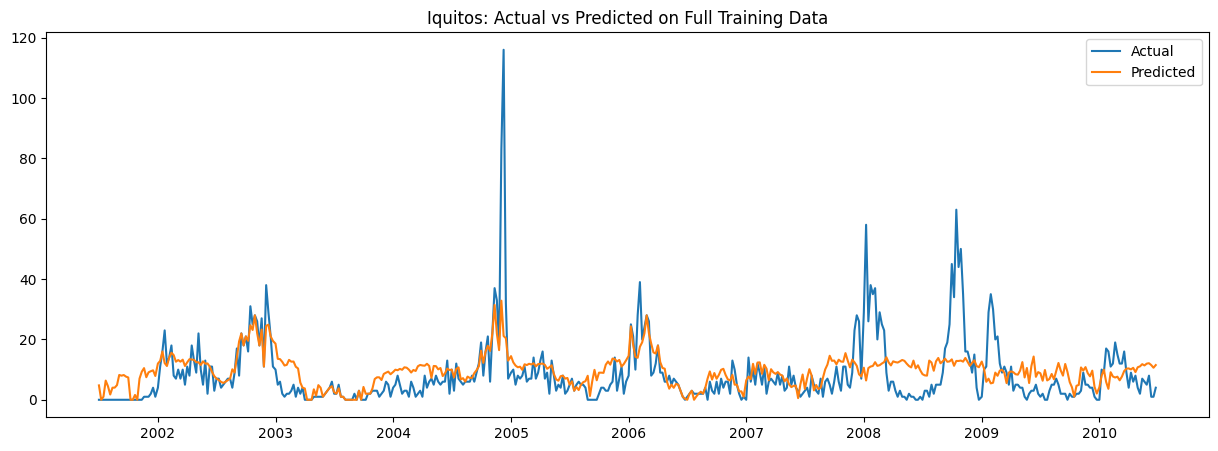

In [25]:
# FIT FINAL MODELS ON FULL TRAINING DATA & VISUALIZE ACTUAL VS PREDICTED

# Final evaluation on training data for San Juan
sj_train_scaled = scaler_sj.transform(sj_train_eng[sj_features_selected])
sj_train_preds = best_model_sj.predict(sj_train_scaled) 
sj_train_preds = np.maximum(sj_train_preds, 0)
mae_sj_train = mean_absolute_error(sj_train_eng['total_cases'], sj_train_preds)
print(f"San Juan Final Model MAE on Full Training Data: {mae_sj_train:.4f}")

# Final evaluation on training data for Iquitos
iq_train_scaled = scaler_iq.transform(iq_train_eng[iq_features_selected])
iq_train_preds = best_model_iq.predict(iq_train_scaled)
iq_train_preds = np.maximum(iq_train_preds, 0)
mae_iq_train = mean_absolute_error(iq_train_eng['total_cases'], iq_train_preds)
print(f"Iquitos Final Model MAE on Full Training Data: {mae_iq_train:.4f}")

# Plot Actual vs Predicted for San Juan
plt.figure(figsize=(15, 5))
plt.plot(sj_train_eng.index, sj_train_eng['total_cases'], label='Actual')
plt.plot(sj_train_eng.index, sj_train_preds, label='Predicted')
plt.title('San Juan: Actual vs Predicted on Full Training Data')
plt.legend()
plt.show()
plt.close()

# Plot Actual vs Predicted for Iquitos
plt.figure(figsize=(15, 5))
plt.plot(iq_train_eng.index, iq_train_eng['total_cases'], label='Actual')
plt.plot(iq_train_eng.index, iq_train_preds, label='Predicted') 
plt.title('Iquitos: Actual vs Predicted on Full Training Data')
plt.legend()

plt.show()
plt.close()

In [27]:
sj_features_selected

['station_max_temp_c_rolling_mean_28',
 'station_max_temp_c_rolling_mean_24',
 'station_diur_temp_rng_c_rolling_skew_52',
 'station_diur_temp_rng_c_rolling_skew_41',
 'station_max_temp_c_rolling_mean_16',
 'precipitation_amt_mm_rolling_std_52',
 'station_min_temp_c_rolling_kurt_16',
 'station_max_temp_c_rolling_median_41',
 'station_diur_temp_rng_c_rolling_std_20',
 'reanalysis_avg_temp_k_rolling_max_52',
 'station_diur_temp_rng_c_rolling_std_16',
 'reanalysis_specific_humidity_g_per_kg_rolling_mean_16',
 'reanalysis_air_temp_k_delta_41',
 'station_min_temp_c_lag_36',
 'reanalysis_relative_humidity_percent_rolling_mean_8',
 'reanalysis_air_temp_k_rolling_var_20',
 'ndvi_ne_rolling_kurt_24']

In [29]:
# FINAL PREDICTIONS ON TEST SET AND SUBMISSION

# 1. Load Test Data
test_features = pd.read_csv(os.path.join(DATA_DIR, 'dengue_features_test.csv'), index_col=[0, 1, 2])

sj_test_features = test_features.loc['sj']
iq_test_features = test_features.loc['iq']

# 2. Preprocess Test Data
sj_test = preprocess_city_data(sj_test_features)
iq_test = preprocess_city_data(iq_test_features)

# 3. Feature Engineering for Test Data (handling lags)
def prepare_test_features(train_df, test_df, selected_features, rolling_weeks=ROLLING_WEEKS, lag_weeks=LAG_WEEKS, delta_weeks=DELTA_WEEKS):
    """
    Combines train tail with test to generate features without NaNs in test.
    """
    # Calculate required history
    # We need enough history to compute the largest lag, rolling window, or delta
    max_lookback = max(max(rolling_weeks), max(lag_weeks), max(delta_weeks)) + 50 # Buffer
    
    # Get last part of training data (features only)
    # Ensure we only take columns present in test (exclude target if present)
    common_cols = [c for c in test_df.columns if c in train_df.columns]
    train_subset = train_df[common_cols].tail(max_lookback)
    
    # Concatenate
    combined = pd.concat([train_subset, test_df[common_cols]])
    
    # Create features
    combined_eng = create_features(combined, lag_weeks=lag_weeks, rolling_weeks=rolling_weeks, delta_weeks=delta_weeks)

    # Keep only selected features
    combined_eng = combined_eng[selected_features]

    # Slice back the test part
    # We use the index of test_df to slice. 
    test_eng = combined_eng.loc[test_df.index]
    
    return test_eng

print("Generating Test Features...")
sj_test_eng = prepare_test_features(sj_train, sj_test, sj_features_selected)
iq_test_eng = prepare_test_features(iq_train, iq_test, iq_features_selected)

# Align test features with training features
# We use the columns from the engineered training set
sj_features_kept = [c for c in sj_train_eng.columns if c != 'total_cases']
iq_features_kept = [c for c in iq_train_eng.columns if c != 'total_cases']

sj_test_eng = sj_test_eng[sj_features_kept]
iq_test_eng = iq_test_eng[iq_features_kept]

print("San Juan Test Shape:", sj_test_eng.shape)
print("Iquitos Test Shape:", iq_test_eng.shape)

# 4. Retrain on Full Data (Train + Val + Test splits)
# We use the best parameters found during tuning
print("\nRetraining San Juan Model on Full Data...")
final_scaler_sj = StandardScaler()
X_train_full_sj_scaled = final_scaler_sj.fit_transform(sj_train_eng[sj_features_kept])
final_model_sj = SVR(**best_model_sj.get_params())
final_model_sj.fit(X_train_full_sj_scaled, sj_train_eng['total_cases'])

print("Retraining Iquitos Model on Full Data...")
final_scaler_iq = StandardScaler()
X_train_full_iq_scaled = final_scaler_iq.fit_transform(iq_train_eng[iq_features_kept])
final_model_iq = SVR(**best_model_iq.get_params())
final_model_iq.fit(X_train_full_iq_scaled, iq_train_eng['total_cases'])

# 5. Predict
sj_test_eng_scaled = final_scaler_sj.transform(sj_test_eng)
sj_preds_final = final_model_sj.predict(sj_test_eng_scaled)
sj_preds_final = np.maximum(sj_preds_final, 0).astype(int)

iq_test_eng_scaled = final_scaler_iq.transform(iq_test_eng)
iq_preds_final = final_model_iq.predict(iq_test_eng_scaled)
iq_preds_final = np.maximum(iq_preds_final, 0).astype(int)

# 6. Create Submission
submission = pd.read_csv(os.path.join(DATA_DIR, "submission_format.csv"), index_col=[0, 1, 2])

# Assign values
submission.loc['sj', 'total_cases'] = sj_preds_final
submission.loc['iq', 'total_cases'] = iq_preds_final

submission.head()

# 7. Save Submission
submission_path = os.path.join(WORKING_DIR, 'results', 'submission_svm.csv')
submission.to_csv(submission_path)

Generating Test Features...
San Juan Test Shape: (260, 17)
Iquitos Test Shape: (156, 24)

Retraining San Juan Model on Full Data...
Retraining Iquitos Model on Full Data...


In [30]:
# SUBMISSION SCORE 26.5409